# STA 208: Homework 4
This is based on the material in Chapters 5,6 of 'Elements of Statistical Learning' (ESL), in addition to lectures 10-13.

## Instructions

We use a script that extracts your answers by looking for cells in between the cells containing the exercise statements (beginning with __Exercise X.X__).  So you 

- MUST add cells in between the exercise statements and add answers within them and
- MUST NOT modify the existing cells, particularly not the problem statement

To make markdown, please switch the cell type to markdown (from code) - you can hit 'm' when you are in command mode - and use the markdown language.  For a brief tutorial see: https://daringfireball.net/projects/markdown/syntax

In the conceptual exercises you should provide an explanation, with math when necessary, for any answers.  When answering with math you should use basic LaTeX, as in 
$$E(Y|X=x) = \int_{\mathcal{Y}} f_{Y|X}(y|x) dy = \int_{\mathcal{Y}} \frac{f_{Y,X}(y,x)}{f_{X}(x)} dy$$
for displayed equations, and $R_{i,j} = 2^{-|i-j|}$ for inline equations.  (To see the contents of this cell in markdown, double click on it or hit Enter in escape mode.)  To see a list of latex math symbols see here: http://web.ift.uib.no/Teori/KURS/WRK/TeX/symALL.html

When writing pseudocode, you should use enumerated lists, such as 

__Algorithm: Ordinary Least Squares Fit__
(Input: X, y; 
Output: $\beta$)
1. Initialize the $p \times p$ Gram matrix, $G \gets 0$, and the vector $b \gets 0$.
2. For each sample, $x_i$:
 1. $G \gets G + x_i x_i^\top$.
 2. $b \gets b + y_i x_i$
3. Solve the linear system $G \beta = b$ and return $\beta$


## Transfusion dataset
Read in the transfusion data using the code below.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import precision_recall_curve, roc_curve

%matplotlib inline

In [2]:
Dtrans = np.loadtxt("transfusion.data",dtype=np.string_,delimiter=",")
print (Dtrans)
X = np.array(Dtrans[1:,0:4],dtype=float)
y = np.array(Dtrans[1:,4],dtype=float)
X = scale(X)

[[b'Recency (months)' b'Frequency (times)' b'Monetary (c.c. blood)'
  b'Time (months)' b'"whether he/she donated blood in March 2007"']
 [b'2 ' b'50' b'12500' b'98 ' b'1']
 [b'0 ' b'13' b'3250' b'28 ' b'1']
 ..., 
 [b'23 ' b'3' b'750' b'62 ' b'0']
 [b'39 ' b'1' b'250' b'39 ' b'0']
 [b'72 ' b'1' b'250' b'72 ' b'0']]


__Exercise 1.1__ (10 pts) Use 5-fold cross validation, leave-one-out CV, and a 50% holdout to tune the bandwidth and ridge penalty parameter for the RBF kernel for SVMs.  Qualitatively compare the results.

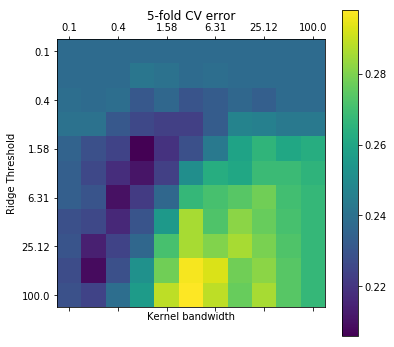

Time spent 7.9 seconds


In [95]:
# 5-fold CV
t0 = time.time()

mesh = 11
splits = 5

C_array = 10**np.linspace(-1,2,mesh)
gamma_array = 10**np.linspace(-1,2,mesh)
errors_fold = np.zeros((mesh,mesh))

kf = KFold(n_splits=5)

for i, C1 in np.ndenumerate(C_array):
    for j, gamma1 in np.ndenumerate(gamma_array):
        clf = SVC(C=C1, gamma=gamma1)
        error = 0
        for train, test in kf.split(X):
            X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
            clf.fit(X_train,y_train)
            y_hat = clf.predict(X_test)
            error += np.mean((y_hat-y_test)**2)
        errors_fold[i,j] = error/splits

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ticks = [10**-1] + np.round(10**np.linspace(-1,2,6), decimals=2).tolist()
plt.xticks(range(mesh), ticks)
plt.yticks(range(mesh), ticks)
ax.set_ylabel('Ridge Threshold')
ax.set_xlabel('Kernel bandwidth')
plt.title('5-fold CV error')
cax = ax.matshow(errors_fold)
plt.colorbar(cax)
plt.show()

t1 = time.time()
print('Time spent %.1f seconds' %(t1-t0))

In [97]:
i,j = np.unravel_index(errors_fold.argmin(), errors_fold.shape)
print("Classification error using 5-fold CV is %.1f%%" %(errors_fold.min()*100))
print('optimal ridge threshold for 5-fold CV is %.3f' %C_array[i])
print('optimal bandwidth for 5-fold CV is %.3f' %gamma_array[j])

Classification error using 5-fold CV is 20.6%
optimal ridge threshold for 5-fold CV is 1.585
optimal bandwidth for 5-fold CV is 0.794


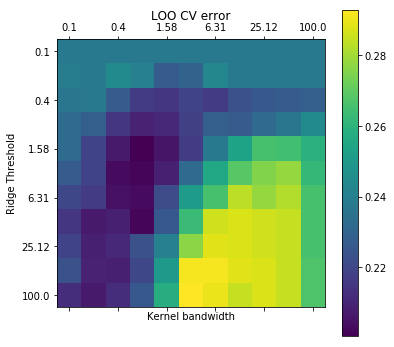

Time spent 1702.1 seconds


In [96]:
# LOO
t0 = time.time()

mesh = 11

C_array = 10**np.linspace(-1,2,mesh)
gamma_array = 10**np.linspace(-1,2,mesh)
errors_loo = np.zeros((mesh,mesh))

loo = LeaveOneOut()

for i, C1 in np.ndenumerate(C_array):
    for j, gamma1 in np.ndenumerate(gamma_array):
        clf = SVC(C=C1, gamma=gamma1)
        error = 0
        n=0
        for train, test in loo.split(X):
            X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
            clf.fit(X_train,y_train)
            y_hat = clf.predict(X_test)
            error += np.mean((y_hat-y_test)**2)
        errors_loo[i,j] = error/np.shape(X)[0]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ticks = [10**-1] + np.round(10**np.linspace(-1,2,6), decimals=2).tolist()
ax.xaxis.set_ticklabels(ticks)
ax.yaxis.set_ticklabels(ticks)
ax.set_ylabel('Ridge Threshold')
ax.set_xlabel('Kernel bandwidth')
plt.title('LOO CV error')
cax = ax.matshow(errors_loo)
plt.colorbar(cax)
plt.show()

t1 = time.time()
print('Time spent %.1f seconds' %(t1-t0))

In [98]:
i,j = np.unravel_index(errors_loo.argmin(), errors_loo.shape)
print("Classification error using LOO CV is %.1f%%" %(errors_loo.min()*100))
print('optimal ridge threshold for LOO CV is %.3f' %C_array[i])
print('optimal bandwidth for LOO CV is %.3f' %gamma_array[j])

Classification error using LOO CV is 20.1%
optimal ridge threshold for LOO CV is 1.585
optimal bandwidth for LOO CV is 0.794


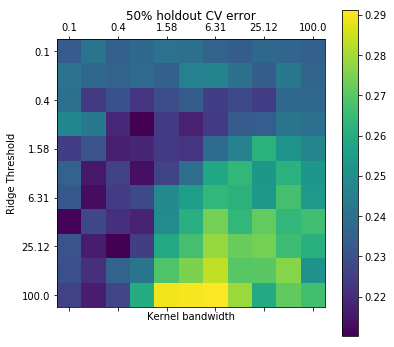

Time spent 10.36 seconds


In [137]:
# 50% holdout
t0 = time.time()

mesh = 11
iterations = 10

C_array = 10**np.linspace(-1,2,mesh)
gamma_array = 10**np.linspace(-1,2,mesh)
errors_hold = np.zeros((mesh,mesh))

for i, C1 in np.ndenumerate(C_array):
    for j, gamma1 in np.ndenumerate(gamma_array):
        clf = SVC(C=C1, gamma=gamma1)
        error = 0
        for _ in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.5)
            clf.fit(X_train,y_train)
            y_hat = clf.predict(X_test)
            error += np.mean((y_hat-y_test)**2)
        errors_hold[i,j] = error/iterations

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ticks = [10**-1] + np.round(10**np.linspace(-1,2,6), decimals=2).tolist()
ax.xaxis.set_ticklabels(ticks)
ax.yaxis.set_ticklabels(ticks)
ax.set_ylabel('Ridge Threshold')
ax.set_xlabel('Kernel bandwidth')
plt.title('10% holdout CV error')
cax = ax.matshow(errors_hold)
plt.colorbar(cax)
plt.show()

t1 = time.time()
print('Time spent %.2f seconds' %(t1-t0))

In [138]:
i,j = np.unravel_index(errors_hold.argmin(), errors_hold.shape)
print("Classification error using 50%% holdout CV is %.1f%%" %(errors_hold.min()*100))
print('optimal ridge threshold for 50%% holdout CV is %.3f' %C_array[i])
print('optimal bandwidth for 50%% holdout CV is %.3f' %gamma_array[j])

Classification error using 50% holdout CV is 21.0%
optimal ridge threshold for 50% holdout CV is 0.794
optimal bandwidth for 50% holdout CV is 0.794


LOO CV took a very long time- 1702 seconds, but gave the most reliable picture. 50% holdout CV is the fastest one, but is really unstable: we need to run several iterations of that to get some stable results, which in the end would put it on par with 5-fold CV time-wise.

In conclusion, 5-fold CV is better.

__Exercise 1.2__ (10 pts) Select one of these methods for tuning the bandwidth parameters and make this a function that takes in a dataset, performs cross-validation, and outputs the tuning parameters.  Make a training and test set split and tune parameters for linear SVMs, RBF kernel SVMs, and logistic regression on the training set, then compare their performances on the test set using ROC and PR curves.

In [111]:
def holdout_CV(X, y, method, percentage=0.5, iterations=1,
               mesh=15, lower_limit=-1, upper_limit=2):
    errors_hold = np.zeros(mesh)
    C_array = 10**np.linspace(lower_limit,upper_limit,mesh)
    for i, C1 in np.ndenumerate(C_array):
        error = 0
        for _ in range(iterations):
            method.set_params(C=C1)
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=percentage)
            clf.fit(X_train,y_train)
            y_hat = clf.predict(X_test)
            error += np.mean((y_hat-y_test)**2)
        errors_hold[i] = error/iterations
    return C_array[np.argmin(errors_hold)]

In [145]:
iterat = 30
split = 0.2

clf1 = SVC(kernel='linear')
X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=split)
C_opt = holdout_CV(X_train, y_train, clf1, iterations=iterat)
clf1.set_params(probability=True, C=C_opt)
clf1.fit(X_train, y_train)
score1 = clf1.predict_proba(X_test)[:,1]

(fpr_lin_svm,tpr_lin_svm,thresholds) = roc_curve(y_test, score1)
(prec_lin_svm,rec_lin_svm,thresholds) = precision_recall_curve(y_test, score1)



clf2 = SVC(kernel='rbf')
X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=split)
C_opt = holdout_CV(X_train, y_train, clf2, iterations=iterat)
clf2.set_params(probability=True, C=C_opt)
clf2.fit(X_train, y_train)
score2 = clf2.predict_proba(X_test)[:,1]

(fpr_rbf_svm,tpr_rbf_svm,thresholds) = roc_curve(y_test, score2)
(prec_rbf_svm,rec_rbf_svm,thresholds) = precision_recall_curve(y_test, score2)



clf3 = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=split)
C_opt = holdout_CV(X_train, y_train, clf3, iterations=iterat)
clf3.set_params(C=C_opt)
clf3.fit(X_train, y_train)
score3 = clf3.predict_proba(X_test)[:,1]

(fpr_log_reg,tpr_log_reg,thresholds) = roc_curve(y_test, score3)
(prec_log_reg,rec_log_reg,thresholds) = precision_recall_curve(y_test, score3)

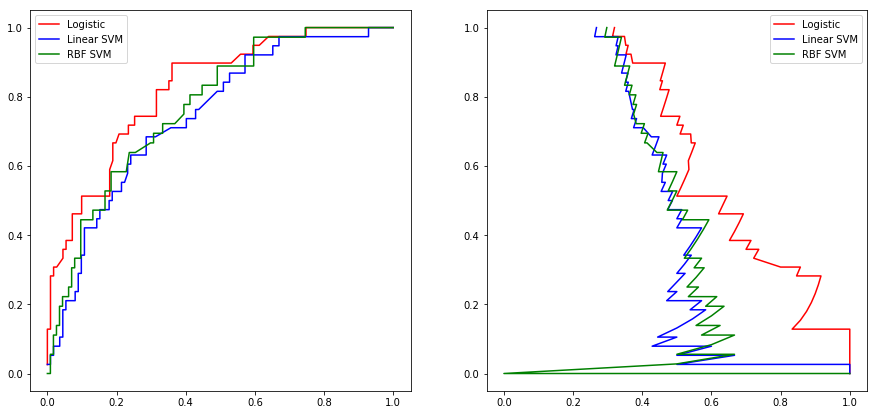

In [144]:
plt.figure(figsize = (15,7))

plt.subplot(121)
logistic, = plt.plot(fpr_log_reg, tpr_log_reg, 'r',label = 'Logistic')
lin_svm, = plt.plot(fpr_lin_svm, tpr_lin_svm, 'b',label = 'Linear SVM')
rbf_svm, = plt.plot(fpr_rbf_svm, tpr_rbf_svm, 'g', label = 'RBF SVM')
plt.legend(handles=[logistic, lin_svm, rbf_svm])

plt.subplot(122)
logistic, = plt.plot(prec_log_reg, rec_log_reg, 'r',label = 'Logistic')
lin_svm, = plt.plot(prec_lin_svm, rec_lin_svm, 'b',label = 'Linear SVM')
rbf_svm, = plt.plot(prec_rbf_svm, rec_rbf_svm, 'g', label = 'RBF SVM')
plt.legend(handles=[logistic,lin_svm,rbf_svm])

plt.show()

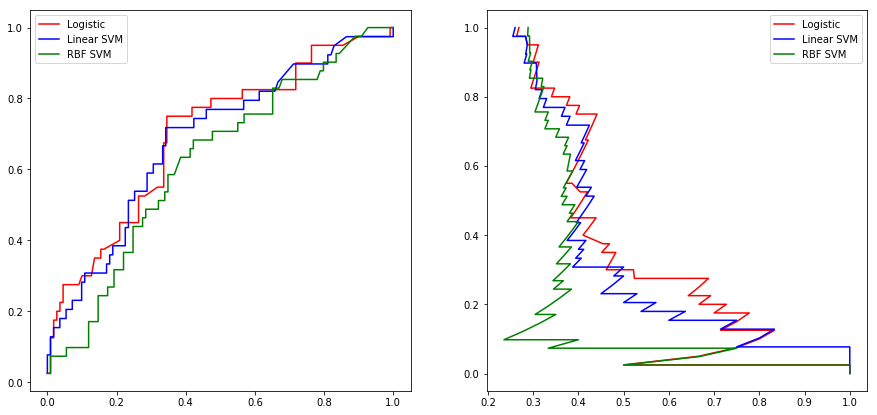

In [146]:
plt.figure(figsize = (15,7))

plt.subplot(121)
logistic, = plt.plot(fpr_log_reg, tpr_log_reg, 'r',label = 'Logistic')
lin_svm, = plt.plot(fpr_lin_svm, tpr_lin_svm, 'b',label = 'Linear SVM')
rbf_svm, = plt.plot(fpr_rbf_svm, tpr_rbf_svm, 'g', label = 'RBF SVM')
plt.legend(handles=[logistic, lin_svm, rbf_svm])

plt.subplot(122)
logistic, = plt.plot(prec_log_reg, rec_log_reg, 'r',label = 'Logistic')
lin_svm, = plt.plot(prec_lin_svm, rec_lin_svm, 'b',label = 'Linear SVM')
rbf_svm, = plt.plot(prec_rbf_svm, rec_rbf_svm, 'g', label = 'RBF SVM')
plt.legend(handles=[logistic,lin_svm,rbf_svm])

plt.show()

We've used the 50% holdout cross-validation here, which turned out to be fairly unstable, even after averaging over several iterations. Above are ROC and PR curves for two different runs, and two pictures don't have a lot in common. Thus, we can't really compare three classification methods based on that type of cross-validation.

## Reuters dataset
The following dataset contains stemmed words from the Reuters dataset, which is articles.  Each line starts with a topic label (of 8 topics) and then has all of the terms in the document.

In [31]:
from collections import Counter
import scipy.sparse as sp
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import confusion_matrix
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
def read_corpus(filename):
    """
    Read a R8 corpus
    Input: filename
    Output: the corpus which is a list of documents with topic labels and stemmed terms
    """
    corpus = []
    DF = Counter()
    label_count = Counter()
    with open(filename,"r") as f:
        for line in f:
            label, terms = line.split('\t')
            terms = terms.strip().split()
            label = label.strip()
            corpus.append([label,Counter(terms)])
            DF += Counter(set(terms))
            label_count += Counter([label])
    return(corpus, DF, label_count)

In [3]:
train_corpus, train_DF, train_label_count = read_corpus('r8-train-stemmed.txt')
test_corpus, test_DF, test_label_count = read_corpus('r8-test-stemmed.txt')

In [4]:
# You should use the document frequency for the whole corpus
full_DF = train_DF + test_DF

In [97]:
## dict_list is the list of dictionary terms, 
## while dict_index can take you from the term back to its index
dict_list = list(full_DF.keys())
dict_index = {t:i for i,t in enumerate(dict_list)}
label_list = list(train_label_count.keys())
label_index = {t:i for i,t in enumerate(label_list)}
print('The labels are encoded by')
print(label_index)

The labels are encoded by
{'earn': 0, 'acq': 1, 'trade': 2, 'ship': 3, 'grain': 4, 'crude': 5, 'interest': 6, 'money-fx': 7}


In [8]:
n, p = len(train_corpus), len(full_DF)
logN = np.log(len(train_corpus) + len(test_corpus))

In [21]:
X_tr = sp.lil_matrix((n,p))

In [109]:
## This creates the sparse training matrix, you will need to modify this to create the test matrix.
## I am using a normalized TFIDF transform below, figure out what it is doing.
y_tr = []
for i in range(n):
    tpc, doc = train_corpus[i]
    vec = np.array([(logN - np.log(train_DF[term]))*doc[term] for term in doc.keys()])
    vec = vec / np.linalg.norm(vec)
    X_tr[i,[dict_index[term] for term in doc.keys()]] = vec
    y_tr.append(label_index[tpc])

m = len(test_corpus)
X_test = sp.lil_matrix((m,p))
y_test = []
for i in range(m):
    tpc, doc = test_corpus[i]
    vec = np.array([(logN - np.log(test_DF[term]))*doc[term] for term in doc.keys()])
    vec = vec / np.linalg.norm(vec)
    X_test[i,[dict_index[term] for term in doc.keys()]] = vec
    y_test.append(label_index[tpc])
    

__Exercise 2.1__ (10 pts) Compute Kmeans with 8 clusters on the training set.  For each cluster, what are the 10 terms that have the highest components in the cluster center vectors?  What are the sizes of the clusters?  Compute a 'confusion matrix' to compare these 8 clusters to the labelled topics (I want an 8 x 8 matrix of counts of documents in each topic and cluster - there are 8 topics).

In [11]:
kmean = KMeans(n_clusters=8, n_init=20).fit(X_tr)

In [121]:
important_words = []
for i in range(8):
    ind = kmean.cluster_centers_[i].argsort()[-10:][::-1]
    words = [list(dict_list)[dex] for dex in ind]
    important_words += set(words)
    print (('The 10 most important keywords for cluster %i are \n' %(i+1)) + str(words[:10]))
important_words = list(important_words)

The 10 most important keywords for cluster 1 are 
['trade', 'oil', 'japan', 'and', 'that', 'billion', 'export', 'offici', 'japanes', 'import']
The 10 most important keywords for cluster 2 are 
['loss', 'profit', 'shr', 'ct', 'net', 'mln', 'rev', 'qtr', 'dlr', 'year']
The 10 most important keywords for cluster 3 are 
['split', 'dividend', 'stock', 'declar', 'payabl', 'april', 'record', 'share', 'board', 'quarterli']
The 10 most important keywords for cluster 4 are 
['qtly', 'div', 'ct', 'record', 'pai', 'prior', 'april', 'march', 'set', 'payout']
The 10 most important keywords for cluster 5 are 
['oper', 'loss', 'net', 'ct', 'dlr', 'shr', 'exclud', 'mln', 'profit', 'gain']
The 10 most important keywords for cluster 6 are 
['and', 'dlr', 'share', 'mln', 'compani', 'for', 'pct', 'offer', 'will', 'billion']
The 10 most important keywords for cluster 7 are 
['mln', 'net', 'ct', 'shr', 'rev', 'qtr', 'avg', 'dlr', 'sale', 'year']
The 10 most important keywords for cluster 8 are 
['bank', 'rat

In [99]:
y_hat = [lab for lab in kmean.labels_]
mat = confusion_matrix(y_tr, y_hat)
print('Confusion matrix is given by')
print(mat)

Confusion matrix is given by
[[   4  511  220  450  235  745  648   27]
 [  23    0    2    0    0 1558    0   13]
 [ 247    0    0    0    0    4    0    0]
 [   5    0    0    0    0  103    0    0]
 [  10    0    0    0    0   31    0    0]
 [ 146    0    0    0    0  107    0    0]
 [  22    0    0    0    0   21    0  147]
 [ 100    0    0    0    0   29    0   77]]


As we see from confusion matrix, k-mean clustering separated class "earn" into 5 clusters (clusters 1,2,3,4 and 6), and put a lot of different elements from different classes into cluster 0. The best result we've got is more or less reliable prediction of class "acq" by cluster 5.

__Exercise 2.2__ (10 pts) Reverse the roles of words and documents and perform hierarchical agglomerative clustering (you can just transpose X) up to 40 clusters.  Compare the dendrograms for three different linkage types, and try to make sense of the resulting clusters.

http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html

In [70]:
X_trun = X_tr[:,[dict_index[word] for word in dict_list if word in important_words]]
X_trun = (X_trun.T).toarray()
AC_ward = AgglomerativeClustering(n_clusters = 40, linkage='ward')
ward_fit = AC_ward.fit(X_trun)

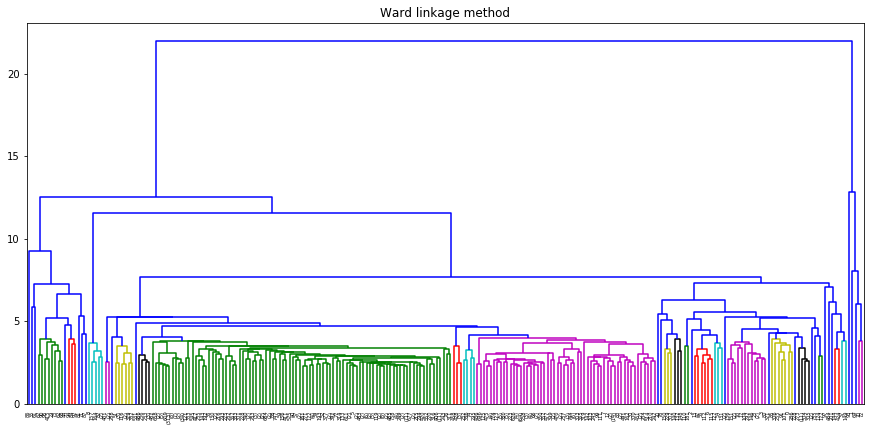

In [92]:
Z_ward = linkage(X_trun, method='ward')
fig = plt.figure(figsize =(15,7))
plt.title('Ward linkage method')
dendrogram(Z_ward, p=250, truncate_mode ='lastp', color_threshold = 4)
plt.show()

In [80]:
AC_comp = AgglomerativeClustering(n_clusters = 40, linkage='complete')
comp_fit = AC_comp.fit(X_trun)

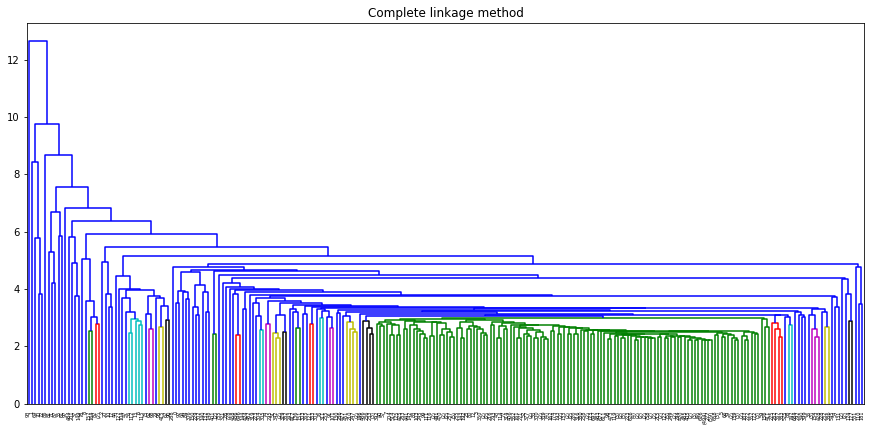

In [93]:
Z_comp = linkage(X_trun, method='complete')
plt.figure(figsize =(15,7))
plt.title('Complete linkage method')
dendrogram(Z_comp, p=250, truncate_mode ='lastp', color_threshold = 3)
plt.show()

In [81]:
AC_ave = AgglomerativeClustering(n_clusters = 40, linkage='average')
ave_fit = AC_ave.fit(X_trun)

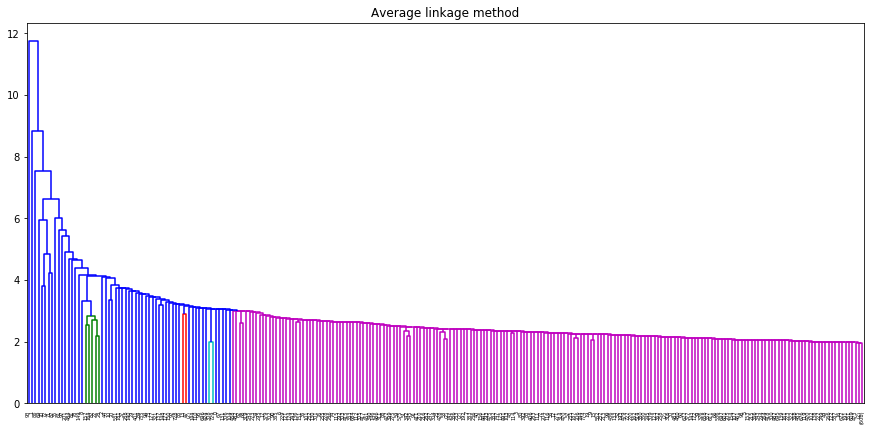

In [94]:
Z_ave = linkage(X_trun, method='average')
plt.figure(figsize =(15,7))
plt.title('Average linkage method')
dendrogram(Z_ave, p=250, truncate_mode ='lastp', color_threshold = 3)
plt.show()

Comparing the dendrogams above, we can conclude that the ward method berforms the best for this classification problem.

__Exercise 2.3__ (10 pts) Use SVMs trained on the training set to predict the test set.  Evaluate the performance with the ROC, PR, and confusion matrix.  Don't forget to appropriately cross-validate to tune parameters.

In [122]:
y_tr_earn = np.array([int(label==0) for label in y_tr])
y_te_earn = np.array([int(label==0) for label in y_test])
X_train = X_tr[:,[dict_index[word] for word in dict_list if word in important_words]].toarray()
X_test1 = X_test[:,[dict_index[word] for word in dict_list if word in important_words]].toarray()

mesh = 5
splits = 5

C_array = 10**np.linspace(-1,2,mesh)
gamma_array = 10**np.linspace(-1,2,mesh)
errors_fold = np.zeros((mesh,mesh))

kf = KFold(n_splits=5)

for i, C1 in np.ndenumerate(C_array):
    for j, gamma1 in np.ndenumerate(gamma_array):
        clf = SVC(C=C1, gamma=gamma1)
        error = 0
        for trainn, testt in kf.split(X_train):
            X_trainn  = X_train[trainn]
            X_testt  = X_train[testt] 
            y_trainn = y_tr_earn[trainn]
            y_testt = y_tr_earn[testt]
            clf.fit(X_trainn,y_trainn)
            y_hat = clf.predict(X_testt)
            error += np.mean((y_hat-y_testt)**2)
        errors_fold[i,j] = error/splits

i,j = np.unravel_index(errors_fold.argmin(), errors_fold.shape)
C_opt = C_array[i]
gamma_opt = gamma_array[j]
clf_opt = SVC(C=C_opt, gamma=gamma_opt)
print('Optimal C is %.1f' %C_opt)
print('Optimal gamma is %.1f' %gamma_opt)



Optimal C is 17.8
Optimal gamma is 3.2


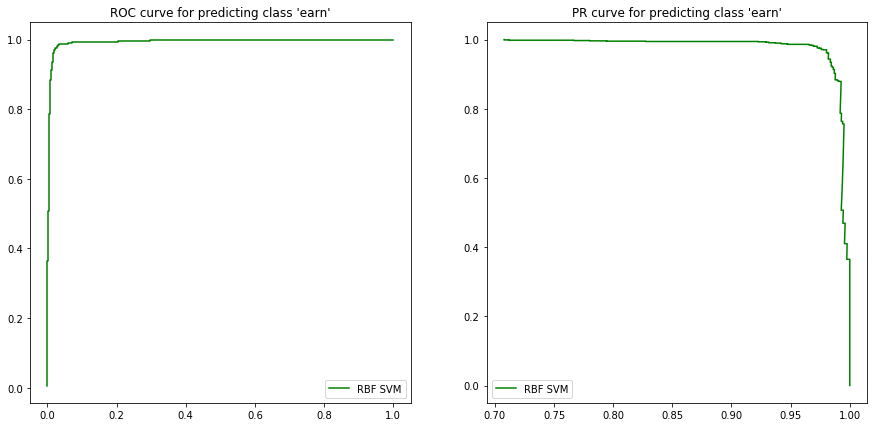

In [132]:
clf_opt = SVC(C=C_opt, gamma=gamma_opt, probability=True)
clf_opt.fit(X_train, y_tr_earn)
score = clf_opt.predict_proba(X_test1)[:,1]
y_hat_earn = clf_opt.predict(X_test1)

(fpr_rbf_svm,tpr_rbf_svm,thresholds) = roc_curve(y_te_earn, score)
(prec_rbf_svm,rec_rbf_svm,thresholds) = precision_recall_curve(y_te_earn, score)

plt.figure(figsize = (15,7))

plt.title("Predicting class 'earn'")

ax1 = plt.subplot(121)
ax1.set_title("ROC curve for predicting class 'earn'")
rbf_svm, = ax1.plot(fpr_rbf_svm, tpr_rbf_svm, 'g', label = 'RBF SVM')
plt.legend(handles=[rbf_svm])

ax2 = plt.subplot(122)
ax2.set_title("PR curve for predicting class 'earn'")
rbf_svm, = ax2.plot(prec_rbf_svm, rec_rbf_svm, 'g', label = 'RBF SVM')
plt.legend(handles=[rbf_svm])

plt.show()

In [129]:
mat = confusion_matrix(y_te_earn, y_hat_earn)
print("Confusion matrix for predicting class 'earn' is")
print(mat)

Confusion matrix for predicting class 'earn' is
[[1039   67]
 [  11 1072]]


Looking at ROC and PR curves wefind that SVM on several important words would give us a good classifier of the class 'earn' vs other classes.